In [2]:
import sys
import copy
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from utils.eda import show_image_with_keypoints, get_image_and_keypoints_from_observation, visualize_duplicates
# preprocessing
from preprocessor.preprocessor import Preprocessor
from torch_dataset.facial_keypoints_dataset import FacialKeypointsDataset
# augmentation
from augmentor.edge_detection.edge_detection import EdgeDetection
from augmentor.image_blurring.image_blurring import ImageBlurring
from augmentor.image_brightness.image_brightness import ImageBrightness
from augmentor.image_flip.image_flip import ImageFlip
from augmentor.image_rotation.image_rotation import ImageRotation
from augmentor.image_sharpening.image_sharpening import ImageSharpening
from augmentor.image_translation.image_translation import ImageTranslation
from augmentor.image_to_tensor.image_to_tensor import ImageToTensor

In [3]:
df_train = pd.read_csv('../data/training.csv')
df_test = pd.read_csv('../data/test.csv')
df_id_table = pd.read_csv('../data/IdLookupTable.csv')

In [4]:
#df_train
df_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
df_train.shape

(7049, 31)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Columns and their types in df_train:

-left(right)_eye_center_x(y) - x(y) coordinate of location of center of left(right) eye on image - float,

-left(right)_eye_inner_corner_x(y) - x(y) coordinate of location of inner corner of left(right) eye - float,

-left(right)_eye_outer_corner_x(y) - x(y) coordinate of location of outer corner of left(right) eye - float,

-left(right)_eyebrow_inner_end_x(y) - x(y) coordinate of location of inner end of left(right) eyebrow - float,

-left(right)_eyebrow_outer_end_x(y) - x(y) coordinate of location of outer end of left(right) eyebrow - float,

-nose_tip_x(y) - x(y) coordinate of tip of nose - float,

-mouth_left(right)_corner_x(y) - x(y) coordinate of location of left(right) corner of mouth - float,

-mouth_center_top(bottom)_lip_x(y) - x(y) coordinate of top(bottom) center of mouth - float,

-Image - matrix representing image - matrix

In [7]:
df=df_train.corr()
df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
left_eye_center_x,1.000000,0.029908,0.274459,-0.154728,0.856572,0.022211,0.879976,0.062128,0.308649,-0.104698,...,0.457468,0.192274,0.422891,0.284087,-0.008382,0.202842,0.260753,0.151302,0.374314,0.265655
left_eye_center_y,0.029908,1.000000,0.259012,0.346331,0.065749,0.926728,-0.013411,0.956066,0.101996,0.537101,...,-0.166891,0.333053,-0.340755,0.480924,-0.392434,0.219366,-0.425576,0.251472,-0.379980,0.130062
right_eye_center_x,0.274459,0.259012,1.000000,0.067621,0.294550,0.127367,-0.024408,0.060942,0.817895,0.090214,...,0.402189,0.024502,0.061124,-0.172144,0.424439,-0.215123,0.308889,-0.109026,0.319541,-0.251105
right_eye_center_y,-0.154728,0.346331,0.067621,1.000000,-0.149295,0.531960,-0.144389,0.221829,0.055758,0.923050,...,0.182866,0.329233,0.312434,0.098019,0.257956,0.397645,0.294145,0.198499,0.344010,0.044597
left_eye_inner_corner_x,0.856572,0.065749,0.294550,-0.149295,1.000000,-0.021444,0.653318,0.080430,0.267661,-0.172852,...,0.387317,-0.054712,0.287427,0.156495,0.145968,0.046439,0.322217,-0.083635,0.242669,0.303769
left_eye_inner_corner_y,0.022211,0.926728,0.127367,0.531960,-0.021444,1.000000,0.010531,0.869743,0.150281,0.710354,...,-0.091006,0.426897,-0.211855,0.493657,-0.335989,0.327081,-0.315929,0.387311,-0.367069,0.308555
left_eye_outer_corner_x,0.879976,-0.013411,-0.024408,-0.144389,0.653318,0.010531,1.000000,0.054156,0.316254,-0.094245,...,0.179189,0.165361,0.507755,0.325291,-0.136411,0.263466,0.229154,0.292129,0.176392,0.332880
left_eye_outer_corner_y,0.062128,0.956066,0.060942,0.221829,0.080430,0.869743,0.054156,1.000000,0.050529,0.373183,...,-0.176047,0.222928,-0.392594,0.506364,-0.462165,0.183239,-0.494482,0.216060,-0.561581,0.329316
right_eye_inner_corner_x,0.308649,0.101996,0.817895,0.055758,0.267661,0.150281,0.316254,0.050529,1.000000,0.124023,...,0.377931,0.118548,0.262597,-0.054888,0.262056,-0.094748,0.369890,0.109785,0.309453,-0.230177
right_eye_inner_corner_y,-0.104698,0.537101,0.090214,0.923050,-0.172852,0.710354,-0.094245,0.373183,0.124023,1.000000,...,0.053212,0.356647,0.237858,0.225398,0.108121,0.449346,0.176403,0.354693,0.203002,0.164086


In [8]:
df_test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [9]:
df_test.shape

(1783, 2)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [11]:
df_id_table.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [12]:
df_id_table.shape

(27124, 4)

In [13]:
df_id_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27124 entries, 0 to 27123
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RowId        27124 non-null  int64  
 1   ImageId      27124 non-null  int64  
 2   FeatureName  27124 non-null  object 
 3   Location     0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 847.8+ KB


## Preprocessing


In [14]:
preprocessor_train = Preprocessor(df_train)
preprocessor_test = Preprocessor(df_test)

In [15]:
print('Preprocessing train dataset..')
preprocessor_train.preprocess_dataset()
df_train = preprocessor_train.df

Preprocessing train dataset..
Handling duplicates...done.
Transforming image column...done.


In [16]:
print('Preprocessing test dataset..')
df_test = preprocessor_test.preprocess_dataset()
df_test = preprocessor_test.df

Preprocessing test dataset..
Handling duplicates...done.
Transforming image column...done.


In [17]:
print("shape of the train dataset after preprocessing: ", df_train.shape)
print("shape of the test dataset after preprocessing: ", df_test.shape)

shape of the train dataset after preprocessing:  (6494, 31)
shape of the test dataset after preprocessing:  (1752, 2)


#### Alter loss function

In [18]:
def MSELoss(output, target):
    filter = ~torch.isnan(target)
    return ((output[filter] - target[filter]) ** 2).mean()

In [19]:
class FacialKeypointsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transforms=None):
        self.df = dataframe
        self.transforms = transforms
        
        self.images = []
        self.keypoints = []
        
        for index, row in self.df.iterrows():
            # Image
            image = row['Image']
            image = np.fromstring(image, sep=' ').reshape([96, 96])
            image = np.stack((image, image, image), axis=-1)
            image = image / 255.0
            
            # Keypoints
            keypoints = row.drop(['Image'])
            keypoints = keypoints.to_numpy().astype('float32')
            
            # Add to Dataset's images and keypoints
            self.images.append(image)
            self.keypoints.append(keypoints)

    def __getitem__(self, idx):
        image = self.images[idx]
        keypoints = self.keypoints[idx]
        
        return_dict = {'image': image, 'keypoints': keypoints}

        if self.transforms:
            return_dict = self.transforms(return_dict)

        return return_dict

    def __len__(self):
        return len(self.df)

7049


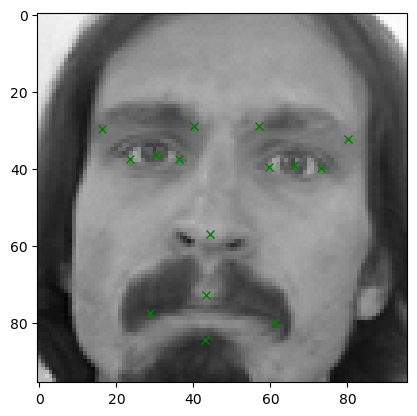

In [20]:
dataset = FacialKeypointsDataset(pd.read_csv('../data/training.csv'))
print(len(dataset))
datapoint = dataset[0]
# print(datapoint)
img = datapoint['image']
keypoints = datapoint['keypoints']
plt.imshow(img, cmap='gray')
plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
plt.show()

In [21]:
class MyToTensor(object):

    def __call__(self, img_with_keypoints):
        image, keypoints = img_with_keypoints["image"], img_with_keypoints["keypoints"]
        image = np.transpose(image, (2, 0, 1)).copy()

        image = torch.from_numpy(image).type(torch.FloatTensor)
        keypoints = torch.from_numpy(keypoints).type(torch.FloatTensor)

        return {'image': image, 'keypoints': keypoints}

### Augmentation

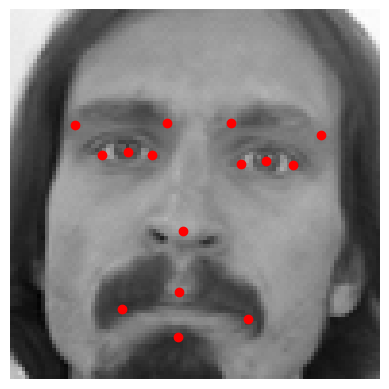

In [22]:
show_image_with_keypoints(datapoint["image"], datapoint["keypoints"].reshape(15,2))

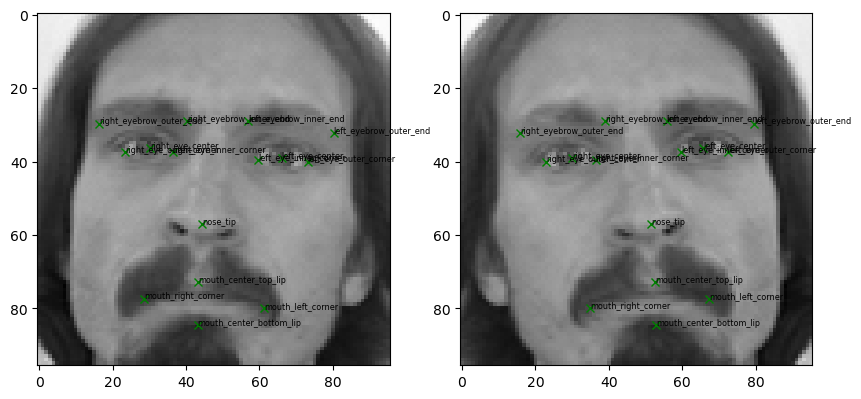

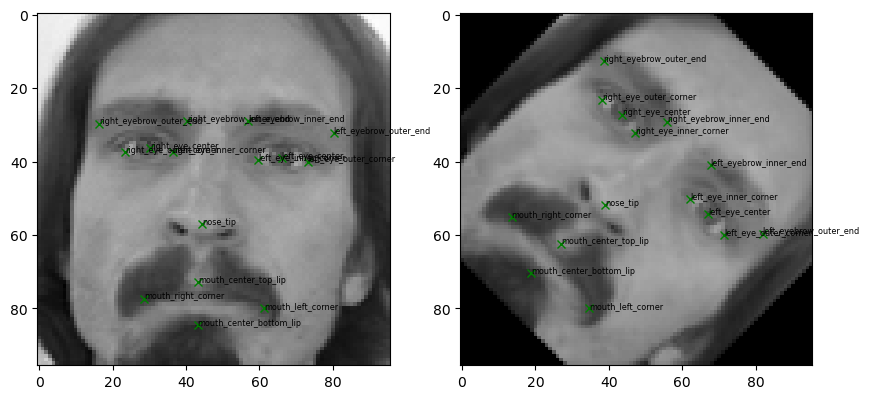

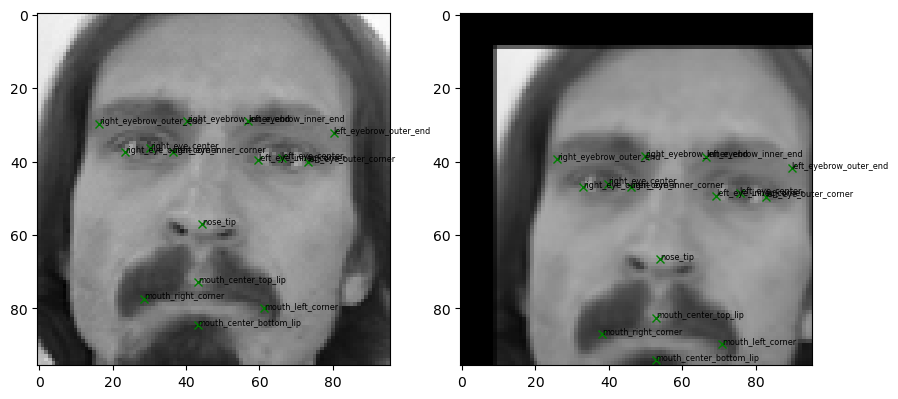

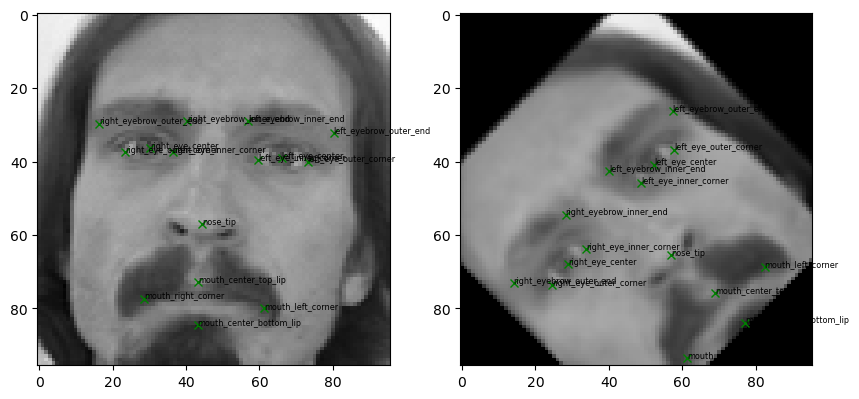

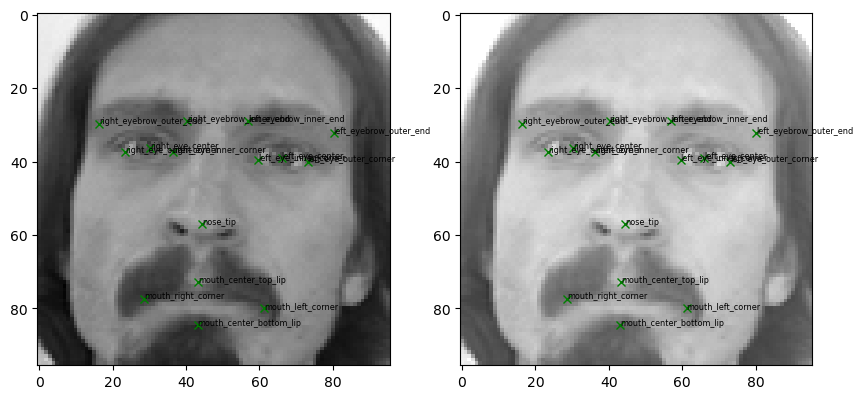

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


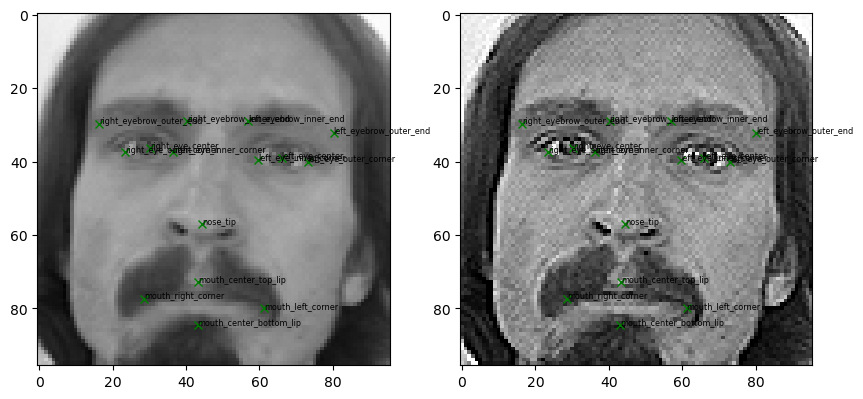

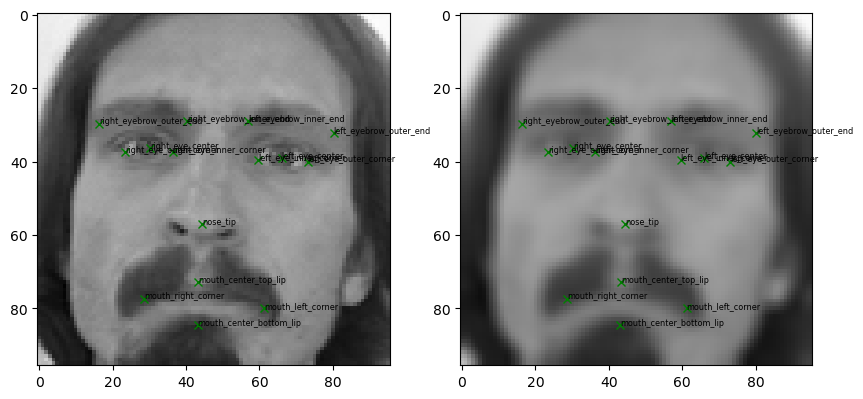

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


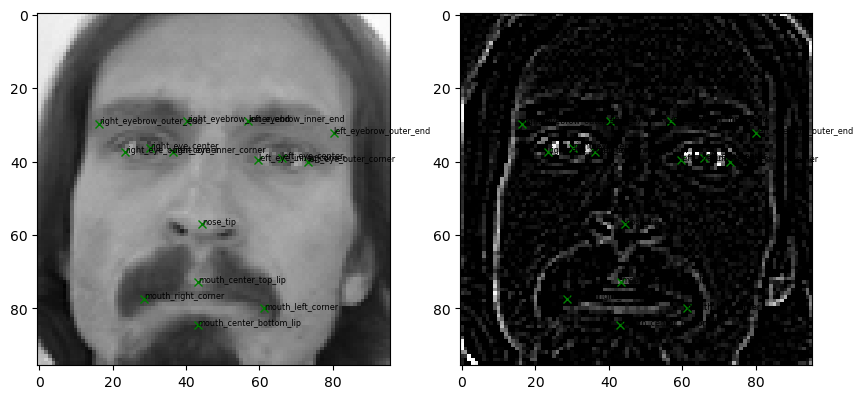

In [23]:
image, keypoints = datapoint["image"], datapoint["keypoints"]
keypoints_columns = df_train.columns[:-1]
random_flip = ImageFlip(probability_threshold=1.0)
random_rotation = ImageRotation(angle=45, probability_threshold=1.0)
random_translation = ImageTranslation(translation_params = (0.1, 0.1), probability_threshold=1.0)
random_brightness = ImageBrightness(brightness=0.2, probability_threshold=1.0)
random_sharpening = ImageSharpening(probability_threshold=1.0)
random_blurring = ImageBlurring(ksize = (5, 5), probability_threshold=1.0)
random_edge_sharpening = EdgeDetection(probability_threshold=1.0)

transform_flip = random_flip(datapoint)
transform_rotation = random_rotation(datapoint)
transform_translation = random_translation(datapoint)
transform_combined = random_flip(random_rotation(random_translation(datapoint)))
transform_brightness = random_brightness(datapoint)
transform_sharpening = random_sharpening(datapoint)
transform_blurring = random_blurring(datapoint)
transform_edge_sharpening = random_edge_sharpening(datapoint)

transforms_list = [transform_flip, transform_rotation, transform_translation, transform_combined, transform_brightness, transform_sharpening,
                   transform_blurring, transform_edge_sharpening]

for transformed_image_with_keypoints in transforms_list:
    transformed_image = transformed_image_with_keypoints["image"]
    transformed_keypoints = transformed_image_with_keypoints["keypoints"]

    fig = plt.figure(figsize=(10, 20))
    # Plot original image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    for i, keypoint_name in enumerate(keypoints_columns[::2]):
        plt.annotate(keypoint_name[:-2],
                     (keypoints[2 * i], keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(keypoints.reshape((15, 2))[:, 0],
             keypoints.reshape((15, 2))[:, 1], 'gx')
    # Plot flipped image
    fig.add_subplot(1, 2, 2)
    plt.imshow(transformed_image, cmap='gray')
    for i, keypoint_name in enumerate(keypoints_columns[::2]):
        plt.annotate(keypoint_name[:-2],
                     (transformed_keypoints[2 * i], transformed_keypoints[2 * i + 1]),
                     fontsize='xx-small')
    plt.plot(transformed_keypoints.reshape((15, 2))[:, 0],
             transformed_keypoints.reshape((15, 2))[:, 1], 'gx')

    plt.show()

In [24]:
train_transform = torchvision.transforms.Compose([
     EdgeDetection(probability_threshold=0.33),
     ImageBlurring(ksize = (5, 5), probability_threshold=0.25),
     ImageBrightness(brightness=0.2, probability_threshold=0.5),
     ImageFlip(probability_threshold=0.5),
     ImageRotation(angle=45, probability_threshold=0.33),
     ImageSharpening(probability_threshold=0.5),
     ImageTranslation(translation_params = (0.1, 0.1), probability_threshold=0.33),
     ImageToTensor()
     ])

val_transform = torchvision.transforms.Compose([ImageToTensor()])
test_transform = torchvision.transforms.Compose([ImageToTensor()])

### Modeling

In [25]:
# training parameters
BATCH_SIZE = 64
EPOCHS = 100
EPOCHS_PRETRAIN = 25

In [26]:
train_size = int(len(dataset) * 0.85)
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_set.dataset.transforms = train_transform
val_set.dataset.transforms = val_transform

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=BATCH_SIZE)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Efficient net

In [57]:
eff = torchvision.models.efficientnet_b7(weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to C:\Users\Krzysztof/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-dcc49843.pth
100%|███████████████████████████████████████████████████████████████████████████████| 255M/255M [00:22<00:00, 11.7MB/s]


In [65]:
num_ftrs = eff.classifier[1].in_features
eff.classifier[1] = torch.nn.Linear(num_ftrs, 30)

In [66]:
#print(vgg19)

In [67]:
eff = eff.type(torch.FloatTensor)
eff = eff.to(device)

### Pretraining

In [68]:
*previous_layers, last_layer = eff.parameters()
for layer in previous_layers:
    layer.requires_grad = False

In [69]:
# set optimizer
optimizer = torch.optim.Adam(eff.parameters(), lr=0.1, weight_decay=0.001)

In [70]:
logger = {'train': [], 'val': []}

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS_PRETRAIN):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS_PRETRAIN}")

    eff.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = eff(x)
        loss = MSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        eff.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = eff(x)
            val_loss += MSELoss(pred, y)

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")


logger_df_pretrained = pd.DataFrame(logger)

EPOCH: 1/25
Average train loss: 13150.938477, Average validation loss: 1981.428345
EPOCH: 2/25
Average train loss: 9195.617188, Average validation loss: 1373.389282
EPOCH: 3/25
Average train loss: 6349.290039, Average validation loss: 944.013306
EPOCH: 4/25
Average train loss: 4337.215332, Average validation loss: 640.789978
EPOCH: 5/25
Average train loss: 2939.528076, Average validation loss: 434.259003
EPOCH: 6/25
Average train loss: 1978.224243, Average validation loss: 291.130554
EPOCH: 7/25
Average train loss: 1323.816284, Average validation loss: 194.747604
EPOCH: 8/25
Average train loss: 882.304016, Average validation loss: 130.697617
EPOCH: 9/25
Average train loss: 590.024719, Average validation loss: 88.337944
EPOCH: 10/25
Average train loss: 400.067596, Average validation loss: 60.998764
EPOCH: 11/25
Average train loss: 277.714386, Average validation loss: 43.763851
EPOCH: 12/25
Average train loss: 201.490555, Average validation loss: 33.382984
EPOCH: 13/25
Average train loss

### Training

In [71]:
for layer in previous_layers:
    layer.requires_grad = True

In [72]:
optimizer = torch.optim.Adam(eff.parameters(), lr=0.0005, weight_decay=0.00005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 25, 40, 65], gamma=0.1)

In [74]:
logger = {'train': [], 'val': []}


best_model = None
min_val_loss = np.inf

train_steps = len(train_set) / BATCH_SIZE
val_steps = len(val_set) / BATCH_SIZE

for epoch in range(EPOCHS):
    torch.manual_seed(1 + epoch)

    print(f"EPOCH: {epoch + 1}/{EPOCHS}")

    eff.train()
    train_loss = 0.0
    for (batch_idx, sample) in enumerate(train_loader):
        x = sample['image']
        y = sample['keypoints']
        (x, y) = (x.to(device), y.to(device))
        pred = eff(x)
        loss = MSELoss(pred, y)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss

    with torch.no_grad():
        eff.eval()
        val_loss = 0.0
        for val_sample in val_loader:
            x = val_sample['image']
            y = val_sample['keypoints']
            (x, y) = (x.to(device), y.to(device))
            pred = eff(x)
            val_loss += MSELoss(pred, y)

    scheduler.step()

    avg_train_loss = train_loss / val_steps
    avg_val_loss = val_loss / val_steps

    logger["train"].append(avg_train_loss.cpu().detach().numpy())
    logger["val"].append(avg_val_loss.cpu().detach().numpy())
    print(f"Average train loss: {avg_train_loss:.6f}, Average validation loss: {avg_val_loss:.6f}")
    
    if min_val_loss > val_loss:
        min_test_loss = val_loss
        best_model = copy.deepcopy(eff)


logger_df = pd.DataFrame(logger)

EPOCH: 1/100
Average train loss: 30.641607, Average validation loss: 6.381802
EPOCH: 2/100
Average train loss: 25.567841, Average validation loss: 5.885366
EPOCH: 3/100
Average train loss: 21.422333, Average validation loss: 4.586901
EPOCH: 4/100
Average train loss: 18.732996, Average validation loss: 4.940372
EPOCH: 5/100
Average train loss: 15.340901, Average validation loss: 4.090597
EPOCH: 6/100
Average train loss: 12.959307, Average validation loss: 3.707946
EPOCH: 7/100
Average train loss: 12.285706, Average validation loss: 3.713559
EPOCH: 8/100
Average train loss: 11.187472, Average validation loss: 3.812872
EPOCH: 9/100
Average train loss: 10.881556, Average validation loss: 3.592912
EPOCH: 10/100
Average train loss: 10.443066, Average validation loss: 3.535140
EPOCH: 11/100
Average train loss: 10.066501, Average validation loss: 3.517456
EPOCH: 12/100
Average train loss: 10.310072, Average validation loss: 3.757703
EPOCH: 13/100
Average train loss: 9.801052, Average validatio

In [82]:
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Loss vizualization

minimum value of the function loss on validation data set:  3.2496824
        train        val
0   30.641607  6.3818016
1    25.56784  5.8853664
2   21.422333  4.5869007
3   18.732996   4.940372
4   15.340901  4.0905967
..        ...        ...
95   9.291084  3.4399037
96   9.235222  3.4697745
97  9.1472435   3.310381
98   9.226043   3.308115
99   9.487518  3.3892403

[100 rows x 2 columns]


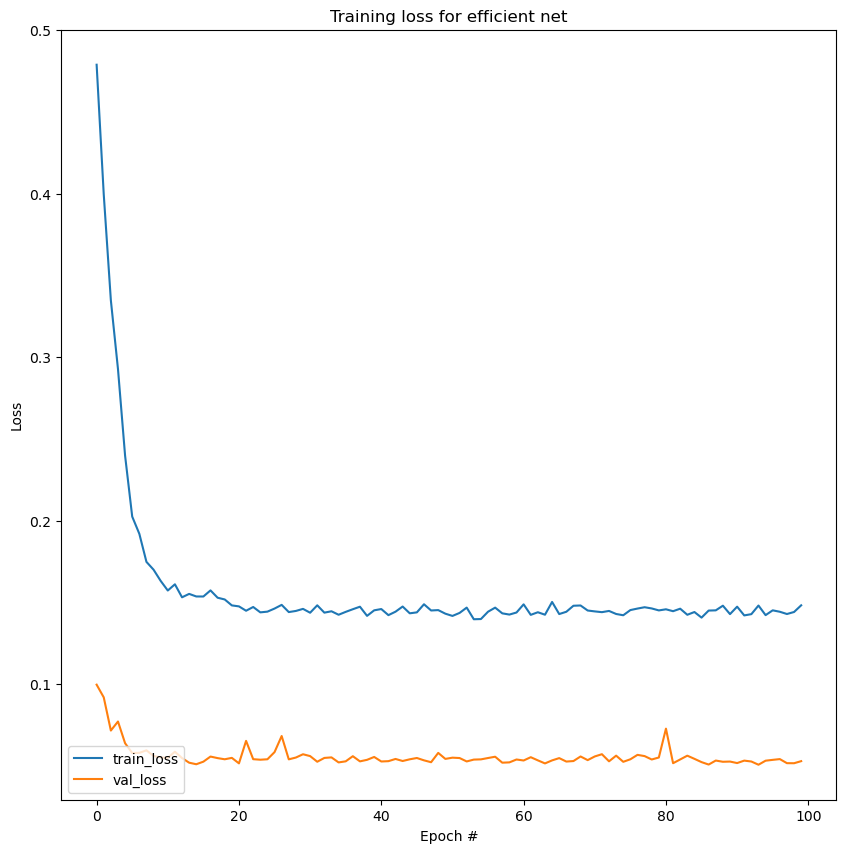

In [79]:
plt.figure(figsize=(10, 10))
plt.plot(logger_df["train"]*train_steps/len(train_set), label="train_loss")
plt.plot(logger_df["val"]*val_steps/len(val_set), label="val_loss")
plt.title("Training loss for efficient net")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
print('minimum value of the function loss on validation data set: ', min(logger_df["val"]))
print(logger_df)

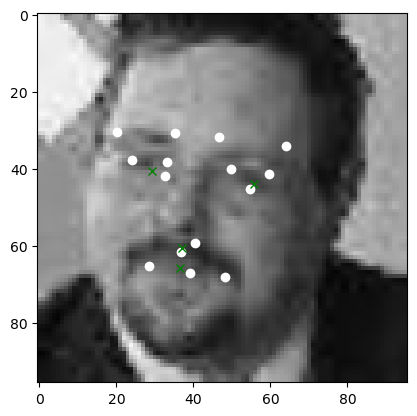

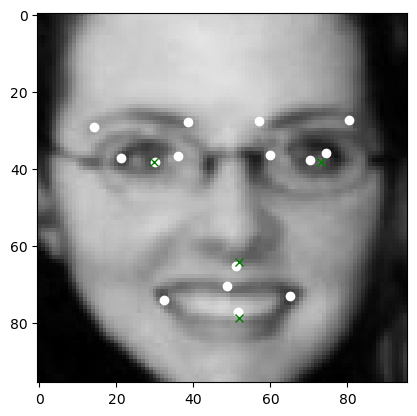

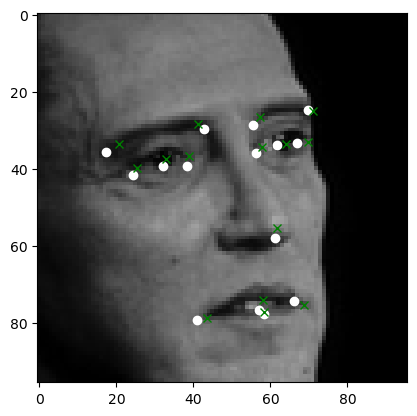

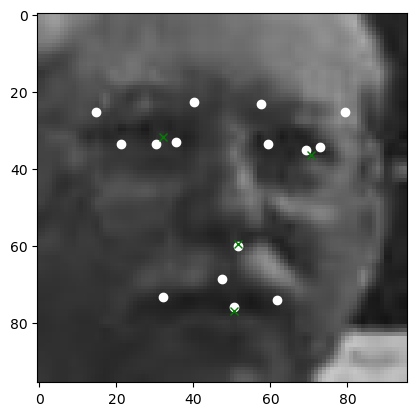

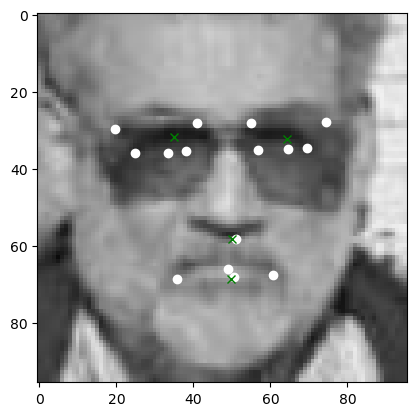

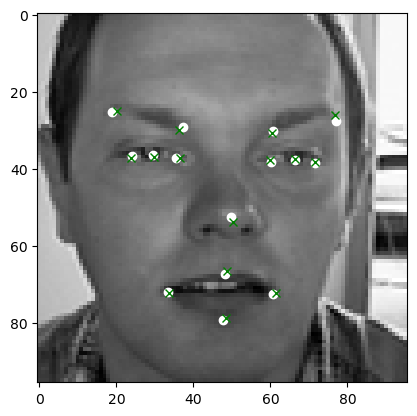

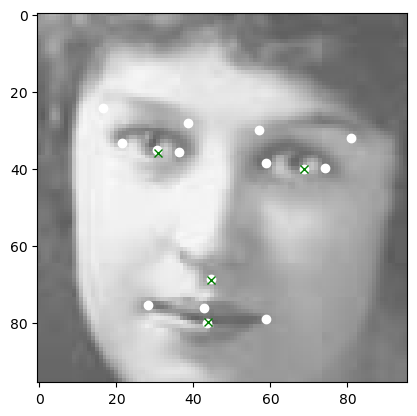

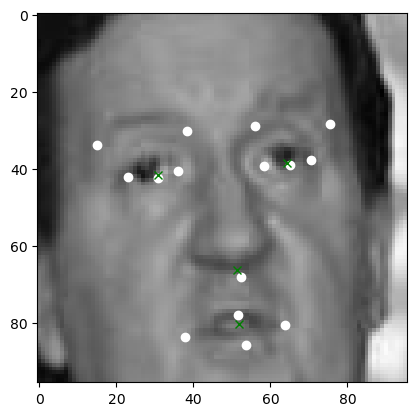

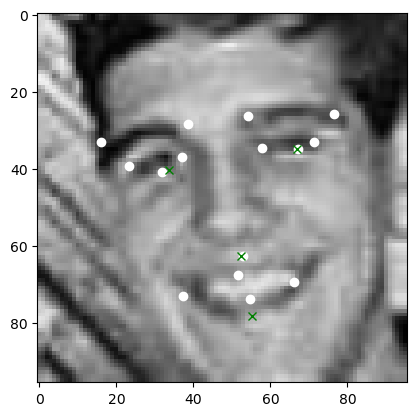

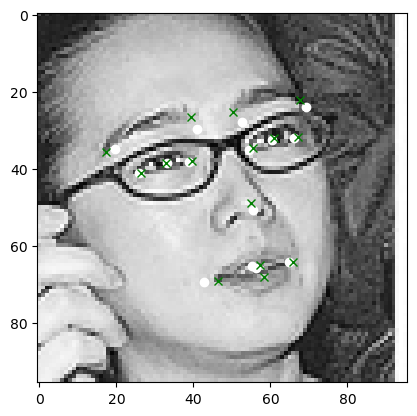

In [77]:
IMAGES_TO_SHOW = 10
val_images_idxs = np.random.randint(0, len(val_set) - 1, 10)
transform = ImageToTensor()
best_model.eval()
for idx in val_images_idxs:
    sample = val_set[idx]
    image = sample['image'].to(device)
    keypoints = sample['keypoints']
    with torch.no_grad():
        pred_keypoints = best_model(image.unsqueeze(0)).cpu().detach().numpy().reshape((30,))
    
    plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.plot(pred_keypoints[0::2], pred_keypoints[1::2], 'wo')
    plt.plot(keypoints[0::2], keypoints[1::2], 'gx')
    plt.show()

In [83]:
print(logger_df)

        train        val
0   30.641607  6.3818016
1    25.56784  5.8853664
2   21.422333  4.5869007
3   18.732996   4.940372
4   15.340901  4.0905967
..        ...        ...
95   9.291084  3.4399037
96   9.235222  3.4697745
97  9.1472435   3.310381
98   9.226043   3.308115
99   9.487518  3.3892403

[100 rows x 2 columns]


In [85]:
sample_submission = pd.read_csv('../data/SampleSubmission.csv')
sample_submission.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [87]:
print(len(df_id_table), len(sample_submission))

27124 27124


In [93]:
columns_keypoints = df_train.columns[:-1]
for column in columns_keypoints:
    df_test[str(column)] = 0.0
df_test.head()

,ImageId,Image,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,1.0,"[[0.7137254901960784, 0.7176470588235294, 0.71...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,"[[0.2980392156862745, 0.3411764705882353, 0.31...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,"[[0.6941176470588235, 0.6901960784313725, 0.68...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,"[[0.6901960784313725, 0.6823529411764706, 0.68...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,"[[0.19607843137254902, 0.1843137254901961, 0.1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
for i, column in enumerate(columns_keypoints):
    print(i, column)

0 left_eye_center_x
1 left_eye_center_y
2 right_eye_center_x
3 right_eye_center_y
4 left_eye_inner_corner_x
5 left_eye_inner_corner_y
6 left_eye_outer_corner_x
7 left_eye_outer_corner_y
8 right_eye_inner_corner_x
9 right_eye_inner_corner_y
10 right_eye_outer_corner_x
11 right_eye_outer_corner_y
12 left_eyebrow_inner_end_x
13 left_eyebrow_inner_end_y
14 left_eyebrow_outer_end_x
15 left_eyebrow_outer_end_y
16 right_eyebrow_inner_end_x
17 right_eyebrow_inner_end_y
18 right_eyebrow_outer_end_x
19 right_eyebrow_outer_end_y
20 nose_tip_x
21 nose_tip_y
22 mouth_left_corner_x
23 mouth_left_corner_y
24 mouth_right_corner_x
25 mouth_right_corner_y
26 mouth_center_top_lip_x
27 mouth_center_top_lip_y
28 mouth_center_bottom_lip_x
29 mouth_center_bottom_lip_y


In [95]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

best_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [96]:
for row_idx, test_row in df_test.iterrows():
    image = test_row['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96])
    image = np.stack((image, image, image), axis=-1)
    image = image / 255.0
    image = test_transform(image)
    image = image.unsqueeze(0)
    image = image.type(torch.FloatTensor)
    image = image.to(device)
    
    with torch.no_grad():
        pred_keypoints = best_model(image).cpu().detach().numpy().reshape((30,))
        
    for column_idx, column in enumerate(columns_keypoints):
        df_test.at[row_idx, column] = pred_keypoints[column_idx]
df_test.head()

C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_3040\1971969451.py:3: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  image = np.fromstring(image, sep=' ').reshape([96, 96])


ValueError: cannot reshape array of size 0 into shape (96,96)

In [108]:
np.fromstring(df_test[['Image']][0], sep=' ')

KeyError: 0

In [109]:
!pip install dill

In [110]:
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
dill.dump_session(filename)